In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os

In [4]:
# Paths to the dataset folders
dataset_path = "Variant-a(Multiclass classification)"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")


In [5]:
# Create data generators for train and validation datasets
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load datasets from directories
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3162 images belonging to 8 classes.
Found 902 images belonging to 8 classes.


In [6]:
# Initialize the VGG16 model (without the top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Determine the number of classes in the dataset
num_classes = len(train_generator.class_indices)

# Add custom layers for transfer learning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model for transfer learning
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base VGG16 model
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Save the best model during training
checkpoint = ModelCheckpoint('final_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

print("Model training complete. Saved as 'final_model.keras'.")

Epoch 1/10


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.4656 - loss: 2.0101 - val_accuracy: 0.6375 - val_loss: 0.9827
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.6680 - loss: 0.8970 - val_accuracy: 0.7206 - val_loss: 0.7782
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 396s 4s/step - accuracy: 0.7390 - loss: 0.7553 - val_accuracy: 0.7328 - val_loss: 0.7280
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.7567 - loss: 0.6595 - val_accuracy: 0.7506 - val_loss: 0.7181
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.7677 - loss: 0.5937 - val_accuracy: 0.7140 - val_loss: 0.8125
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8006 - loss: 0.5694 - val_accuracy: 0.7683 - val_loss: 0.6309
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.7947 - loss: 0.5678 - val_accuracy: 0.7738 - val_loss: 0.6124
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.8193 - loss: 0.4812 - val_accuracy: 0.8016 - val_loss: 0.

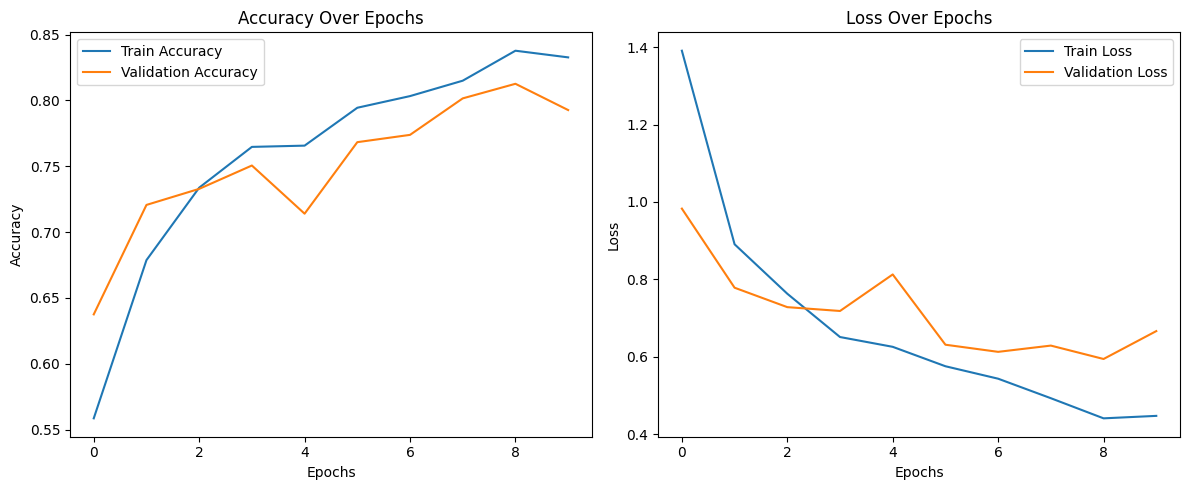

In [9]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('final_model.keras')

# Function to load and preprocess the custom image for prediction
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image
    img_array = preprocess_input(img_array)
    return img_array

# Function to make predictions, wrapped in tf.function for efficiency
@tf.function
def make_prediction(img_array):
    return model(img_array, training=False)

#path to the custom image 
img_path = "IMG20220324110332_2.jpg"

img_array = preprocess_image(img_path)

# Get the prediction using tf.function to avoid retracing
prediction = make_prediction(img_array)

predicted_class_index = np.argmax(prediction, axis=1)

class_labels = list(train_generator.class_indices.keys())

predicted_class = class_labels[predicted_class_index[0]]

# Check if the predicted class is 'healthy' or an infected class
if predicted_class.lower() == 'healthy':
    print("The plant is healthy.")
else:
    print(f"The plant is infected with: {predicted_class}.")


The plant is infected with: Pottassium Deficiency.
